<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day27_Smart_Calendar_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept:**
 Event extraction and scheduling optimization

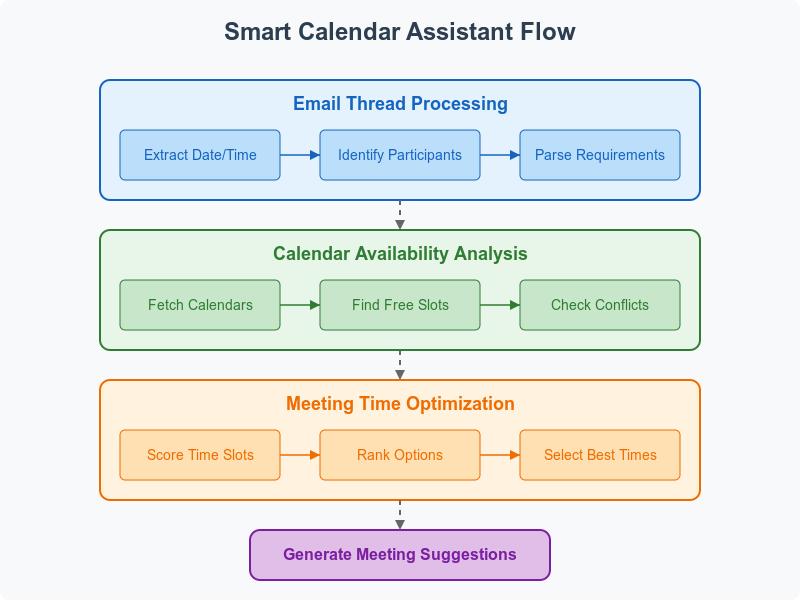

**Smart Calendar Assistant Explained Simply**
Imagine we have email threads where people discuss meeting times like "Can we meet next Tuesday?" or "I'm free Thursday afternoon." This project builds a tool that reads these emails, identifies when people are discussing meetings, extracts the date/time information, and then checks everyone's calendars for the best available slots.

**For example**, if Slade emails Bob saying "Let's meet next week to discuss the project," our assistant would analyze both their calendars, find common free periods (like Tuesday 2-3pm), and suggest: "Based on your discussion about meeting next week, I recommend Tuesday at 2pm when you're both available."

The tool combines **natural language processing** to understand meeting requests with scheduling algorithms to find optimal meeting times, saving you from the back-and-forth emails typically needed to schedule meetings.

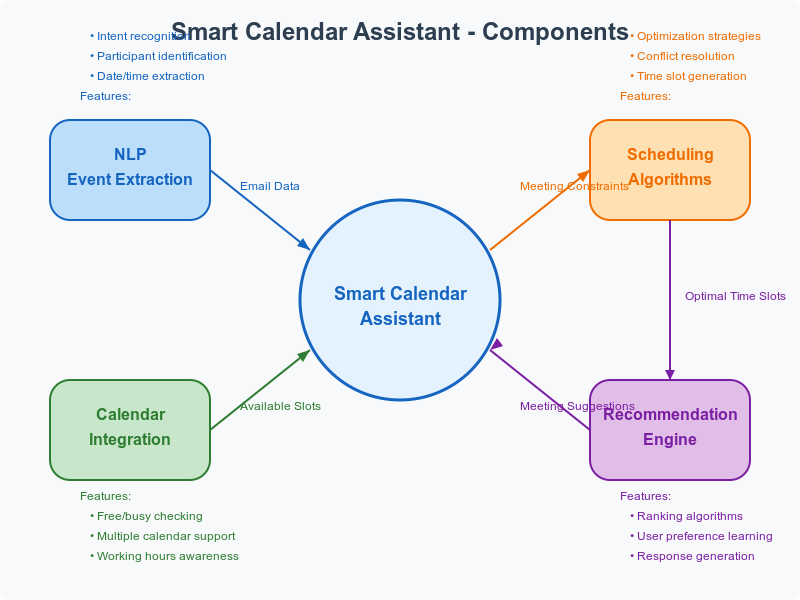

**Setting Up Your Environment**

In [1]:
# Install required libraries
!pip install nltk pandas matplotlib dateparser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.1 MB/s eta 0:00:00


**Import Libraries**

In [5]:
import nltk
import pandas as pd
import dateparser
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary NLTK data, including punkt_tab for tokenization.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the punkt_tab resource

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

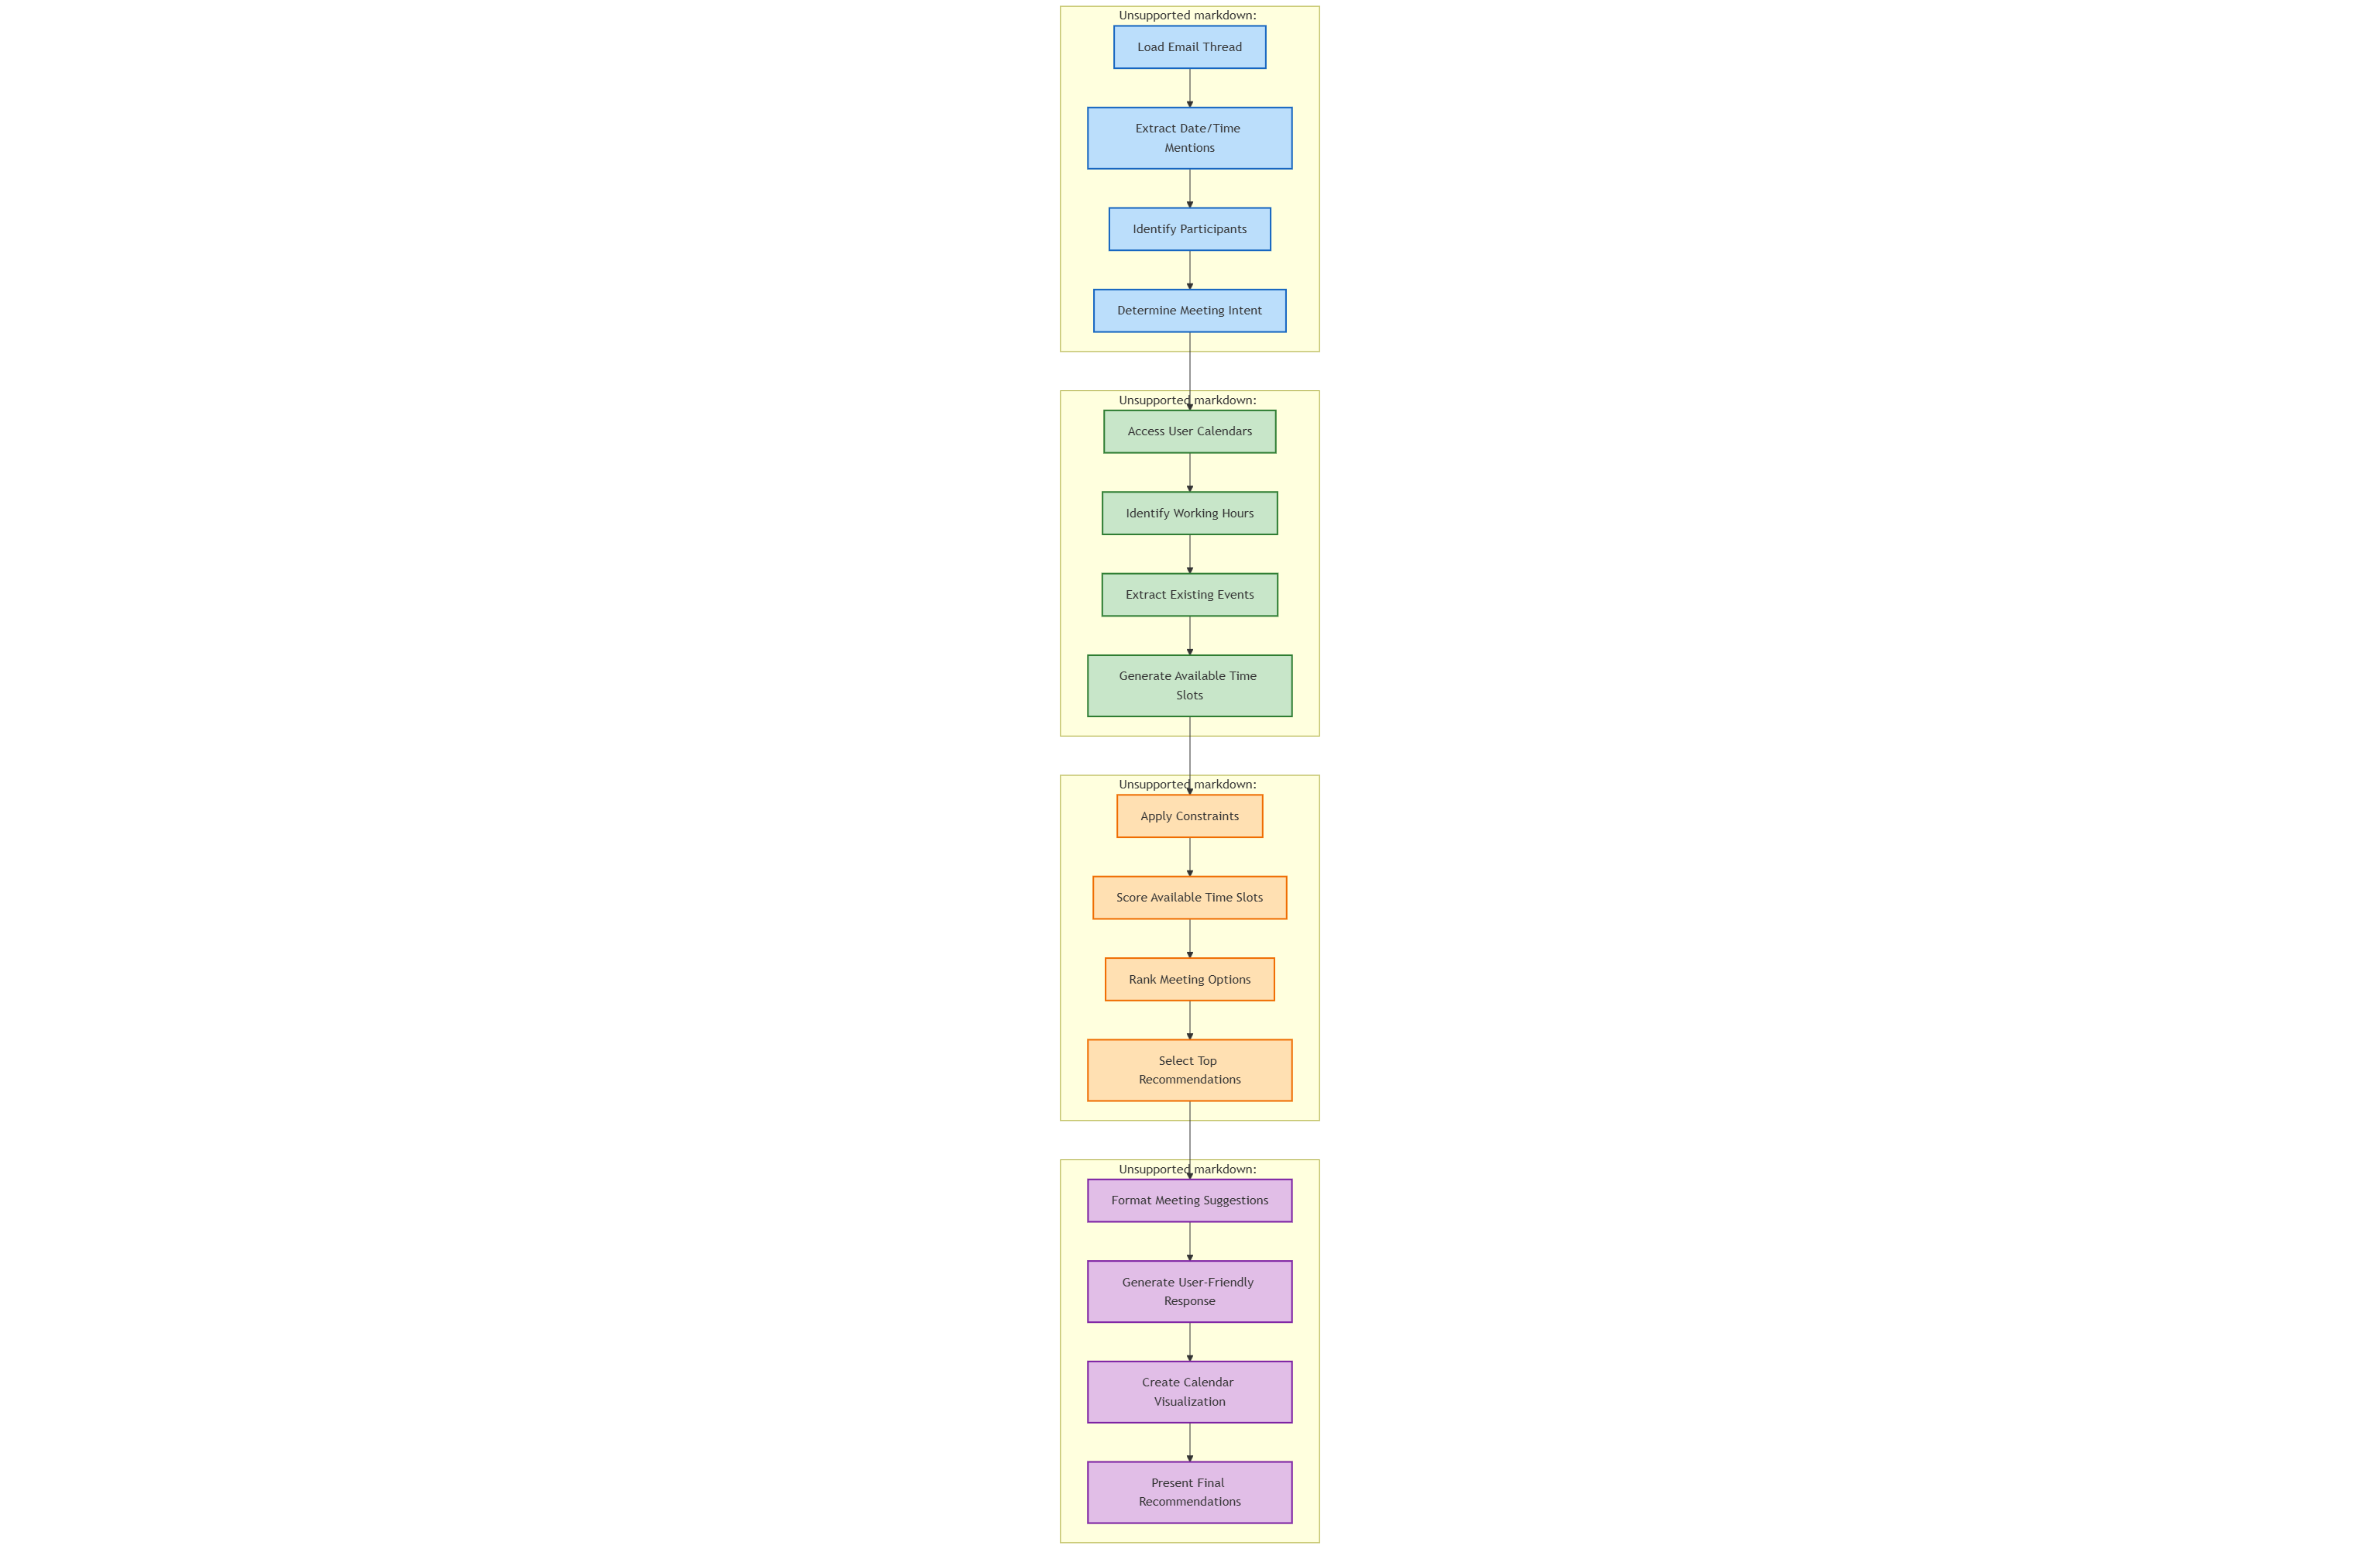

**Create Sample Data**

In [3]:
# Sample email messages discussing meetings
emails = [
    {
        "from": "alice@example.com",
        "to": "bob@example.com",
        "subject": "Project Meeting",
        "body": "Hi Bob, Can we meet next Tuesday at 2pm to discuss the project progress? Let me know if that works for you.",
        "date": "2025-05-01"
    },
    {
        "from": "bob@example.com",
        "to": "alice@example.com",
        "subject": "Re: Project Meeting",
        "body": "Hi Alice, Tuesday at 2pm doesn't work for me. I'm available Wednesday morning or Thursday afternoon.",
        "date": "2025-05-02"
    },
    {
        "from": "charlie@example.com",
        "to": ["alice@example.com", "bob@example.com"],
        "subject": "Team Sync",
        "body": "Team, we need to schedule a quick sync. How about Friday at 10am?",
        "date": "2025-05-03"
    }
]

# Mock calendar data
calendar_data = {
    "alice@example.com": [
        {"title": "Meeting with Manager", "start": "2025-05-13 10:00", "end": "2025-05-13 11:00"},
        {"title": "Lunch", "start": "2025-05-13 12:00", "end": "2025-05-13 13:00"},
        {"title": "Doctor Appointment", "start": "2025-05-14 09:00", "end": "2025-05-14 10:30"},
        {"title": "Team Meeting", "start": "2025-05-15 14:00", "end": "2025-05-15 15:00"}
    ],
    "bob@example.com": [
        {"title": "Client Call", "start": "2025-05-13 14:00", "end": "2025-05-13 15:00"},
        {"title": "Lunch", "start": "2025-05-13 12:00", "end": "2025-05-13 13:00"},
        {"title": "Project Review", "start": "2025-05-14 11:00", "end": "2025-05-14 12:00"},
        {"title": "1:1 with Manager", "start": "2025-05-15 10:00", "end": "2025-05-15 11:00"}
    ]
}

**Extract Date and Time Mentions from Emails**

In [6]:
def extract_date_time_mentions(text):
    """Extract potential date and time mentions from text"""
    # Regular expressions for common time patterns
    time_patterns = [
        r'\d{1,2}(?::\d{2})?\s*(?:am|pm|AM|PM)',  # 2pm, 2:30pm
        r'\d{1,2}\s*(?:am|pm|AM|PM)',             # 2pm, 2 pm
        r'(?:morning|afternoon|evening|noon)'      # morning, afternoon
    ]

    # Regular expressions for date patterns
    date_patterns = [
        r'(?:next|this)\s+(?:monday|tuesday|wednesday|thursday|friday|saturday|sunday)',  # next Monday
        r'tomorrow',
        r'today',
        r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{1,2}(?:st|nd|rd|th)?',  # May 15th
    ]

    # Combine all patterns
    all_patterns = time_patterns + date_patterns

    # Find all matches
    matches = []
    for pattern in all_patterns:
        matches.extend(re.findall(pattern, text.lower()))

    # Use dateparser for comprehensive date/time extraction
    words = word_tokenize(text)
    window_size = 5  # Check combinations of words

    for i in range(len(words) - window_size + 1):
        for j in range(1, window_size + 1):
            phrase = ' '.join(words[i:i+j])
            parsed_date = dateparser.parse(phrase)
            if parsed_date is not None:
                matches.append(phrase)

    # Remove duplicates and return
    return list(set(matches))

# Test the function
for email in emails:
    print(f"From: {email['from']}")
    print(f"Subject: {email['subject']}")
    print(f"Date/Time Mentions: {extract_date_time_mentions(email['body'])}")
    print("-" * 50)

From: alice@example.com
Subject: Project Meeting
Date/Time Mentions: ['to', ', Can', 'at 2pm', 'Can', 'me', '2pm', 'next tuesday', 'Tuesday', '2pm to', 'Tuesday at', 'Tuesday at 2pm']
--------------------------------------------------
From: bob@example.com
Subject: Re: Project Meeting
Date/Time Mentions: ['morning', 'Wednesday', 'at 2pm', "n't", '. I', 'me', '2pm', 'me .', 'afternoon', ', Tuesday at 2pm', 'Tuesday', "'m", 'I', 'Tuesday at 2pm', 'Tuesday at', ', Tuesday at', ', Tuesday']
--------------------------------------------------
From: charlie@example.com
Subject: Team Sync
Date/Time Mentions: ['to', 'about Friday at 10am', 'a', 'about Friday at', 'about Friday', 'about Friday at 10am ?', '10am']
--------------------------------------------------


**Check Calendar Availability**

In [7]:
def get_available_slots(email_addresses, date, start_hour=9, end_hour=17, slot_duration=30):
    """Find available time slots in given calendars"""
    # Convert date string to datetime
    target_date = datetime.strptime(date, "%Y-%m-%d")

    # Initialize time slots (30-minute intervals by default)
    slots = []
    current_time = target_date.replace(hour=start_hour, minute=0)
    end_time = target_date.replace(hour=end_hour, minute=0)

    while current_time < end_time:
        slot_end = current_time + timedelta(minutes=slot_duration)
        slots.append((current_time, slot_end))
        current_time = slot_end

    # Check which slots are available for all participants
    available_slots = []

    for slot_start, slot_end in slots:
        is_available = True

        for email in email_addresses:
            if email in calendar_data:
                # Check against this person's calendar
                for event in calendar_data[email]:
                    event_start = datetime.strptime(event["start"], "%Y-%m-%d %H:%M")
                    event_end = datetime.strptime(event["end"], "%Y-%m-%d %H:%M")

                    # Check if there's an overlap
                    if (slot_start < event_end and slot_end > event_start):
                        is_available = False
                        break

            if not is_available:
                break

        if is_available:
            available_slots.append((slot_start, slot_end))

    return available_slots

# Example: Check availability for Alice and Bob on May 13, 2025
available = get_available_slots(
    ["alice@example.com", "bob@example.com"],
    "2025-05-13"
)

print("Available slots on May 13, 2025:")
for start, end in available:
    print(f"{start.strftime('%H:%M')} - {end.strftime('%H:%M')}")

Available slots on May 13, 2025:
09:00 - 09:30
09:30 - 10:00
11:00 - 11:30
11:30 - 12:00
13:00 - 13:30
13:30 - 14:00
15:00 - 15:30
15:30 - 16:00
16:00 - 16:30
16:30 - 17:00


**Recommend Meeting Times Based on Email Thread**

In [8]:
def suggest_meeting_times(emails, max_suggestions=3):
    """Analyze email thread and suggest optimal meeting times"""
    participants = set()
    date_mentions = []

    # Extract participants and date/time mentions
    for email in emails:
        participants.add(email["from"])
        if isinstance(email["to"], list):
            participants.update(email["to"])
        else:
            participants.add(email["to"])

        # Extract date mentions
        mentions = extract_date_time_mentions(email["body"])
        date_mentions.extend(mentions)

    # Process date mentions to identify target dates
    target_dates = []
    for mention in date_mentions:
        parsed_date = dateparser.parse(mention)
        if parsed_date is not None:
            target_date = parsed_date.strftime("%Y-%m-%d")
            if target_date not in target_dates:
                target_dates.append(target_date)

    # If no clear dates found, use next business day
    if not target_dates:
        today = datetime.now()
        next_day = today + timedelta(days=1)
        # Skip to Monday if it's Friday
        if next_day.weekday() >= 5:  # 5=Saturday, 6=Sunday
            next_day = today + timedelta(days=(7 - today.weekday()))
        target_dates = [next_day.strftime("%Y-%m-%d")]

    # Find available slots for each target date
    suggestions = []

    for date in target_dates:
        available_slots = get_available_slots(list(participants), date)

        # Add suggestions with date information
        for start, end in available_slots[:max_suggestions]:
            suggestions.append({
                "date": date,
                "start_time": start.strftime("%H:%M"),
                "end_time": end.strftime("%H:%M"),
                "participants": list(participants)
            })

    return suggestions[:max_suggestions]

# Test the function
suggestions = suggest_meeting_times(emails)
print("\nMeeting Suggestions:")
for suggestion in suggestions:
    print(f"Date: {suggestion['date']}")
    print(f"Time: {suggestion['start_time']} - {suggestion['end_time']}")
    print(f"Participants: {', '.join(suggestion['participants'])}")
    print("-" * 30)


Meeting Suggestions:
Date: 2025-05-08
Time: 09:00 - 09:30
Participants: bob@example.com, charlie@example.com, alice@example.com
------------------------------
Date: 2025-05-08
Time: 09:30 - 10:00
Participants: bob@example.com, charlie@example.com, alice@example.com
------------------------------
Date: 2025-05-08
Time: 10:00 - 10:30
Participants: bob@example.com, charlie@example.com, alice@example.com
------------------------------


**Visualize Calendar and Suggestions**

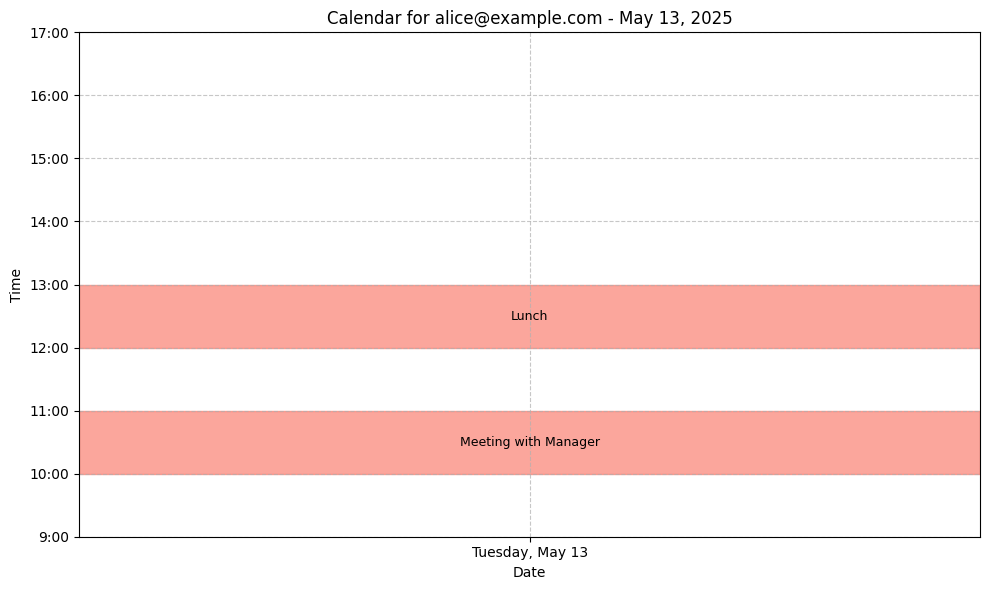

In [9]:
def visualize_calendar_and_suggestions(email, date, suggestions):
    """Create a visualization of a user's calendar with suggested meeting times"""
    # Convert date string to datetime
    target_date = datetime.strptime(date, "%Y-%m-%d")

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Business hours
    hours = list(range(9, 18))  # 9 AM to 5 PM

    # Set up y-axis (hours)
    ax.set_yticks(range(len(hours)))
    ax.set_yticklabels([f"{h}:00" for h in hours])

    # Set up x-axis (just one day)
    ax.set_xticks([0.5])
    ax.set_xticklabels([target_date.strftime("%A, %b %d")])

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Plot existing calendar events
    if email in calendar_data:
        for event in calendar_data[email]:
            event_start = datetime.strptime(event["start"], "%Y-%m-%d %H:%M")
            event_end = datetime.strptime(event["end"], "%Y-%m-%d %H:%M")

            # Check if event is on target date
            if event_start.date() == target_date.date():
                # Calculate position
                start_pos = (event_start.hour - 9) + (event_start.minute / 60)
                duration = (event_end - event_start).total_seconds() / 3600  # hours

                # Draw event
                ax.add_patch(plt.Rectangle((0, start_pos), 1, duration, color='salmon', alpha=0.7))
                ax.text(0.5, start_pos + duration/2, event["title"],
                        ha='center', va='center', fontsize=9)

    # Plot suggested meeting times
    for suggestion in suggestions:
        suggestion_date = datetime.strptime(suggestion["date"], "%Y-%m-%d")
        if suggestion_date.date() == target_date.date():
            start_hour, start_minute = map(int, suggestion["start_time"].split(":"))
            end_hour, end_minute = map(int, suggestion["end_time"].split(":"))

            start_pos = (start_hour - 9) + (start_minute / 60)
            duration = (end_hour - start_hour) + ((end_minute - start_minute) / 60)

            # Draw suggestion
            ax.add_patch(plt.Rectangle((0, start_pos), 1, duration, color='lightgreen', alpha=0.7))
            ax.text(0.5, start_pos + duration/2, "Suggested Meeting",
                    ha='center', va='center', fontsize=9)

    # Add title and labels
    ax.set_title(f"Calendar for {email} - {target_date.strftime('%B %d, %Y')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Time")

    plt.tight_layout()
    plt.show()

# Visualize Alice's calendar with suggestions
visualize_calendar_and_suggestions("alice@example.com", "2025-05-13", suggestions)

**Format Results for Presentation**

In [10]:
def generate_assistant_response(emails, suggestions):
    """Generate a human-readable response from the assistant"""
    if not suggestions:
        return "I couldn't find any suitable meeting times based on the email thread and calendar availability."

    # Extract the original meeting request details
    original_request = None
    for email in emails:
        if "meet" in email["body"].lower() or "schedule" in email["body"].lower():
            original_request = email
            break

    if original_request:
        response = f"Based on the email thread started by {original_request['from']} "
        response += f"about \"{original_request['subject']}\", I recommend the following meeting times:\n\n"
    else:
        response = "Based on the email thread, I recommend the following meeting times:\n\n"

    # Add suggestions
    for i, suggestion in enumerate(suggestions, 1):
        day_of_week = datetime.strptime(suggestion["date"], "%Y-%m-%d").strftime("%A")
        response += f"{i}. {day_of_week}, {suggestion['date']} from {suggestion['start_time']} to {suggestion['end_time']}\n"

    # Add context
    response += "\nThese times work for all participants: "
    response += ", ".join(suggestions[0]["participants"])

    return response

# Generate assistant response
response = generate_assistant_response(emails, suggestions)
print("\n========== Smart Calendar Assistant Response ==========\n")
print(response)


========== Smart Calendar Assistant Response ==========

Based on the email thread started by alice@example.com about "Project Meeting", I recommend the following meeting times:

1. Thursday, 2025-05-08 from 09:00 to 09:30
2. Thursday, 2025-05-08 from 09:30 to 10:00
3. Thursday, 2025-05-08 from 10:00 to 10:30

These times work for all participants: bob@example.com, charlie@example.com, alice@example.com


**Create a Complete Function**

In [11]:
def smart_calendar_assistant(email_thread):
    """Main function to process email threads and suggest meeting times"""
    print("📬 Processing email thread...")
    print(f"Thread contains {len(email_thread)} messages\n")

    # Extract date/time mentions
    print("🔍 Extracting date and time mentions:")
    for email in email_thread:
        mentions = extract_date_time_mentions(email["body"])
        print(f"  - From '{email['from']}': {', '.join(mentions) if mentions else 'No specific mentions'}")

    # Get participants
    participants = set()
    for email in email_thread:
        participants.add(email["from"])
        if isinstance(email["to"], list):
            participants.update(email["to"])
        else:
            participants.add(email["to"])

    print(f"\n👥 Participants: {', '.join(participants)}")

    # Generate suggestions
    print("\n🗓️ Checking calendar availability...")
    suggestions = suggest_meeting_times(email_thread)

    if not suggestions:
        print("❌ No suitable times found that work for all participants.")
        return

    # Display suggestions
    print(f"\n✅ Found {len(suggestions)} suitable meeting times:")
    for i, suggestion in enumerate(suggestions, 1):
        day = datetime.strptime(suggestion["date"], "%Y-%m-%d").strftime("%A")
        print(f"  {i}. {day}, {suggestion['date']} at {suggestion['start_time']}-{suggestion['end_time']}")

    # Generate response
    response = generate_assistant_response(email_thread, suggestions)

    print("\n💬 Assistant Response:")
    print("-" * 50)
    print(response)
    print("-" * 50)

    # Return the suggestions and response
    return {
        "suggestions": suggestions,
        "response": response
    }

# Run the complete assistant
result = smart_calendar_assistant(emails)

📬 Processing email thread...
Thread contains 3 messages

🔍 Extracting date and time mentions:
  - From 'alice@example.com': to, , Can, at 2pm, Can, me, 2pm, next tuesday, Tuesday, 2pm to, Tuesday at, Tuesday at 2pm
  - From 'bob@example.com': morning, Wednesday, at 2pm, n't, . I, me, 2pm, me ., afternoon, , Tuesday at 2pm, Tuesday, 'm, I, Tuesday at 2pm, Tuesday at, , Tuesday at, , Tuesday
  - From 'charlie@example.com': to, about Friday at 10am, a, about Friday at, about Friday, about Friday at 10am ?, 10am

👥 Participants: bob@example.com, charlie@example.com, alice@example.com

🗓️ Checking calendar availability...

✅ Found 3 suitable meeting times:
  1. Thursday, 2025-05-08 at 09:00-09:30
  2. Thursday, 2025-05-08 at 09:30-10:00
  3. Thursday, 2025-05-08 at 10:00-10:30

💬 Assistant Response:
--------------------------------------------------
Based on the email thread started by alice@example.com about "Project Meeting", I recommend the following meeting times:

1. Thursday, 2025-05-